In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

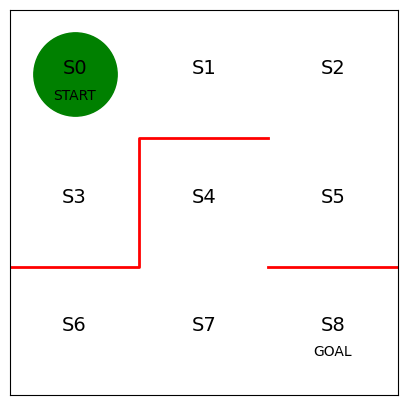

In [21]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

# plt.plot([1, 1], [0, 1], color='red', linewidth=2)
# plt.plot([1, 2], [2, 2], color='red', linewidth=2)
# plt.plot([2, 2], [2, 1], color='red', linewidth=2)
# plt.plot([2, 3], [1, 1], color='red', linewidth=2)

plt.plot([2, 3], [1, 1], color='red', linewidth=2)
plt.plot([0, 1, 1, 2], [1, 1, 2, 2], color='red', linewidth=2)

plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')
# plt.axis('off')
plt.tick_params(axis='both', which='both', 
                bottom=False, top=False, 
                right=False, left=False,
                labelbottom=False, labelleft=False
               )
line, = ax.plot([0.5], [2.5], marker='o', color='g', markersize=60)

## basics

- 基本概念及术语
    - algorithm
        - policy iteration
            - policy gradient
        - value iteration
            - sarsa： state, action, reward, state, action
                - Q-table：待学习（learning/iteration update)
                    - row index: state; column index: action;
                    - 不是概率分布，是 value
            - q-learning
    - reward
        - 特定时间 $t$ 给到的奖励 $R_t$ 称为即时奖励（immediate reward）
        - 未来的总奖励 $G_t$
            - $G_t=R_{t+1}+R_{t+2}+R_{t+3}+\cdots$
            - $G_t=R_{t+1}+\gamma R_{t+2}+\gamma^2R_{t+3} + \cdots + \gamma^kR_{t+k+1}\cdots$
        - 举例
            - $Q_\pi(s=7,a=1)=R_{t+1}=1$
            - $Q_\pi(s=7,a=0)=\gamma^2$
    - action value，state value
    - bellman equation
        - 适用于状态价值函数（state value function），也适用于动作价值函数（action value function）
    - mdp：markov decision process
        - 马尔可夫性
            - $p(s_{t+1}|s_t)=p(s_{t+1}|{s_1,s_2,s_3,\cdots,s_t})$
        - bellman equation 成立的前提条件

- $R_t$
- $Q_{\pi}(s,a)$：state action value function
    - Q table
    - 通过 Sarsa 算法迭代更新 $Q_{\pi}(s,a)$
- 对于强化学习而言
    - state, action, reward 都是需要精心设计的

## Sarsa（state action reward state action）

In [3]:
# border & barrier
# ↑, →, ↓, ←（顺时针）
# row index: given state
# col index: posible action
# (state, action) matrix
# 跟环境对齐
theta_0 = np.asarray([[np.nan, 1, 1, np.nan],      # s0
                      [np.nan, 1, np.nan, 1],      # s1
                      [np.nan, np.nan, 1, 1],      # s2
                      [1, np.nan, np.nan, np.nan], # s3 
                      [np.nan, 1, 1, np.nan],      # s4
                      [1, np.nan, np.nan, 1],      # s5
                      [np.nan, 1, np.nan, np.nan], # s6 
                      [1, 1, np.nan, 1]]           # s7
                     )

In [4]:
n_states, n_actions = theta_0.shape

In [5]:
# Q table, 状态是离散的（s0-s7），动作也是离散的（上右下左）
Q = np.random.rand(n_states, n_actions) * theta_0

In [6]:
Q

array([[       nan, 0.89619489, 0.64439937,        nan],
       [       nan, 0.13020354,        nan, 0.14894768],
       [       nan,        nan, 0.46292249, 0.56390384],
       [0.28943659,        nan,        nan,        nan],
       [       nan, 0.72971053, 0.62042612,        nan],
       [0.6938756 ,        nan,        nan, 0.73133186],
       [       nan, 0.23229058,        nan,        nan],
       [0.97220162, 0.81266061,        nan, 0.92701024]])

### $\epsilon$-greedy (explore, exploit)

In [7]:
# 基于占比, 最 naive 的概率化方式
def cvt_theta_0_to_pi(theta):
    m, n = theta.shape
    pi = np.zeros((m, n))
    for r in range(m):
        pi[r, :] = theta[r, :] / np.nansum(theta[r, :])
    return np.nan_to_num(pi)

In [8]:
pi_0 = cvt_theta_0_to_pi(theta_0)

In [9]:
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.        , 0.33333333]])

In [10]:
Q

array([[       nan, 0.89619489, 0.64439937,        nan],
       [       nan, 0.13020354,        nan, 0.14894768],
       [       nan,        nan, 0.46292249, 0.56390384],
       [0.28943659,        nan,        nan,        nan],
       [       nan, 0.72971053, 0.62042612,        nan],
       [0.6938756 ,        nan,        nan, 0.73133186],
       [       nan, 0.23229058,        nan,        nan],
       [0.97220162, 0.81266061,        nan, 0.92701024]])

In [11]:
# epsilon-greedy
def get_action(s, Q, eps, pi_0):
    action_space = list(range(4))
    # eps, explore
    if np.random.rand() < eps:
        action = np.random.choice(action_space, p=pi_0[s, :])
    else:
        # 1-eps, exploit
        action = np.nanargmax(Q[s, :])
    return action

### Sarsa (update $Q_\pi(s,a)$)

理想情况下：
$$
Q(s_t,a_t) = R_{t+1}+\gamma Q(s_{t+1}, a_{t+1})
$$

- td (temporal difference error)
    - $R_{t+1}+\gamma Q(s_{t+1},a_{t+1})-Q(s_t,a_t)$
- final update equation
    - $Q(s_t,a_t)=Q(s_t,a_t)+\eta\cdot(R_{t+1}+\gamma Q(s_{t+1},a_{t+1})-Q(s_t,a_t))$
    - $s_t,a_t,r_{t+1},s_{t+1},a_{t+1}$

- 折扣（discount factor，$\gamma$）
    - 有助于缩短步数（更快地结束任务）；

In [12]:
def sarsa(s, a, r, s_next, a_next, Q, eta, gamma):
    if s_next == 8:
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])

## 解决 maze 问题

In [13]:
# 维护着状态，以及 step 函数的返回
class MazeEnv(gym.Env):
    def __init__(self):
        self.state = 0
        pass
    
    def reset(self):
        self.state = 0
        return self.state
    
    def step(self, action):
        if action == 0:
            self.state -= 3
        elif action == 1:
            self.state += 1
        elif action == 2:
            self.state += 3
        elif action == 3:
            self.state -= 1
        done = False
        reward = 0
        if self.state == 8:
            done = True
            reward = 1
        # state, reward, done, _
        return self.state, reward, done, {}

In [14]:
# 动作策略选择，基于当前环境的状态
class Agent:
    def __init__(self):
        self.action_space = list(range(4))
        self.theta_0 = np.asarray([[np.nan, 1, 1, np.nan],      # s0
                      [np.nan, 1, np.nan, 1],      # s1
                      [np.nan, np.nan, 1, 1],      # s2
                      [1, np.nan, np.nan, np.nan], # s3 
                      [np.nan, 1, 1, np.nan],      # s4
                      [1, np.nan, np.nan, 1],      # s5
                      [np.nan, 1, np.nan, np.nan], # s6 
                      [1, 1, np.nan, 1]]           # s7
                     )
        self.pi = self._cvt_theta_to_pi()
#         self.pi = self._softmax_cvt_theta_to_pi()
#         self.theta = self.theta_0

        self.Q = np.random.rand(*self.theta_0.shape) * self.theta_0
        self.eta = 0.1
        self.gamma = 0.9
        self.eps = 0.5
        
    def _cvt_theta_to_pi(self):
        m, n = self.theta_0.shape
        pi = np.zeros((m, n))
        for r in range(m):
            pi[r, :] = self.theta_0[r, :] / np.nansum(self.theta_0[r, :])
        return np.nan_to_num(pi)
    
#     def _softmax_cvt_theta_to_pi(self, beta=1.):
#         m, n = self.theta.shape
#         pi = np.zeros((m, n))
#         exp_theta = np.exp(self.theta*beta)
#         for r in range(m):
#             pi[r, :] = exp_theta[r, :] / np.nansum(exp_theta[r, :])
#         return np.nan_to_num(pi)
    
    def get_action(self, s):
        # eps, explore
        if np.random.rand() < self.eps:
            action = np.random.choice(self.action_space, p=self.pi[s, :])
        else:
            # 1-eps, exploit
            action = np.nanargmax(self.Q[s, :])
        return action
        
    def sarsa(self, s, a, r, s_next, a_next):
        if s_next == 8:
            self.Q[s, a] = self.Q[s, a] + self.eta * (r - self.Q[s, a])
        else:
            self.Q[s, a] = self.Q[s, a] + self.eta * (r + self.gamma * self.Q[s_next, a_next] - self.Q[s, a])

## 完成训练及更新

In [15]:
maze = MazeEnv()
agent = Agent()
epoch = 0
while True:
    old_Q = np.nanmax(agent.Q, axis=1)
    s = maze.reset()
    a = agent.get_action(s)
    s_a_history = [[s, np.nan]]
    while True:
        # s, a 
        s_a_history[-1][1] = a
        s_next, reward, done, _ = maze.step(a, )
        # s_next, a_next
        s_a_history.append([s_next, np.nan])
        if done:
            a_next = np.nan
        else:
            a_next = agent.get_action(s_next)
#         print(s, a, reward, s_next, a_next)
        agent.sarsa(s, a, reward, s_next, a_next)
#         print(agent.pi)
        if done:
            break
        else:
            a = a_next
            s = maze.state

    # s_s_history, agent.Q
    update = np.sum(np.abs(np.nanmax(agent.Q, axis=1) - old_Q))
    epoch +=1
    agent.eps /= 2
    print(epoch, update, len(s_a_history))
    if epoch > 100 or update < 1e-5:
        break


1 0.48353288884314183 27
2 0.2597360276600632 25
3 0.22371107057058598 25
4 0.09280378842767906 7
5 0.07879688388347136 7
6 0.06681680659451109 7
7 0.056611496778147835 7
8 0.04868301202634101 7
9 0.04506330285162363 7
10 0.041953237852393244 7
11 0.039269094035133734 7
12 0.037858126922750146 7
13 0.036921995338253855 7
14 0.03600268880526136 7
15 0.03509304104006866 7
16 0.034188165029197526 7
17 0.03328499026542403 7
18 0.03238187214952182 7
19 0.03147826476353405 7
20 0.03057444892257477 7
21 0.029671308132990737 7
22 0.02877014580137488 7
23 0.027872537734185354 7
24 0.026980214629683585 7
25 0.026094969884706165 7
26 0.02521858861378501 7
27 0.024352794305079528 7
28 0.023499210016053096 7
29 0.022659331442716923 7
30 0.02183450958142885 7
31 0.02102594104414418 7
32 0.020234664389583767 7
33 0.01946156109712449 7
34 0.018707360040538135 7
35 0.017972644518206682 7
36 0.017257861068242952 7
37 0.016563329443983643 7
38 0.01588925325044227 7
39 0.015235730848042306 7
40 0.01460276

In [16]:
agent.Q

array([[       nan, 0.5852829 , 0.12915098,        nan],
       [       nan, 0.65377865,        nan, 0.14634178],
       [       nan,        nan, 0.72813243, 0.14984396],
       [0.34027545,        nan,        nan,        nan],
       [       nan, 0.47670806, 0.89994983,        nan],
       [0.5531822 ,        nan,        nan, 0.80974753],
       [       nan, 0.80855124,        nan,        nan],
       [0.82733375, 0.99999497,        nan, 0.815092  ]])

## 可视化

In [17]:
from matplotlib import animation
from IPython.display import HTML

In [18]:
def init():
    line.set_data([], [])
    return (line, )
def animate(i):
    state = s_a_history[i][0]
    x = (state % 3)+0.5
    y = 2.5 - int(state/3)
    line.set_data([x], [y])

In [19]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history), interval=200, repeat=False)

In [20]:
HTML(anim.to_jshtml())